# STDP

Download the Jupyter notebook: [STDP.ipynb](https://raw.githubusercontent.com/ANNarchy/CNS2023/master/src/notebooks/STDP.ipynb){target="_blank"} or run it directly on [colab.](https://colab.research.google.com/github/ANNarchy/CNS2023/blob/master/src/notebooks/STDP.ipynb){target="_blank"}

This notebook demonstrates the online implementation of the spike time-dependent plasticity rule.

In [1]:
#!pip install ANNarchy

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from ANNarchy import *
clear()
setup(dt=1.0)

ANNarchy 4.7 (4.7.2.5) on darwin (posix).


## Model

The STDP learning rule maintains exponentially-decaying traces for the pre-synaptic and post-synaptic spikes.

$$\tau^+ \, \dfrac{d x(t)}{dt} + x (t) = 0$$

$$\tau^- \, \dfrac{d y(t)}{dt} + y(t) = 0$$

LTP and LTD occur at spike times depending on the corresponding traces.

* When a pre-synaptic spike occurs, $x(t)$ is incremented and **LTD** is applied proportionally to $y(t)$.
* When a post-synaptic spike occurs, $y(t)$ is incremented and **LTP** is applied proportionally to $x(t)$.

In [3]:
STDP = Synapse(
    parameters = """
        tau_plus = 20.0 : projection 
        tau_minus = 20.0 : projection
        
        A_plus = 0.01 : projection 
        A_minus = 0.01 : projection
        
        w_min = 0.0 : projection
        w_max = 2.0 : projection
    """,
    equations = """
        # pre-synaptic trace
        tau_plus * dx/dt = -x #: event-driven 
    
        # post-synaptic trace
        tau_minus * dy/dt = -y #: event-driven 
    """,
    pre_spike="""       
        g_target += w
        
        x += A_plus * w_max
        
        w = clip(w - y, w_min , w_max) # LTD
    """,
    post_spike="""  
        y += A_minus * w_max
        
        w = clip(w + x, w_min , w_max) # LTP
    """
)

We create two dummy populations with one neuron each, whose spike times we can control.

In [4]:
pre = SpikeSourceArray([[50.]])
post = SpikeSourceArray([[50.]])

We connect the population using a STDP synapse.

In [5]:
proj = Projection(pre, post, 'exc', STDP)
proj.connect_all_to_all(weights=1.0)

In [6]:
compile()

## STDP mechanism

In [7]:
m = Monitor(proj, ['x', 'y', 'w'])

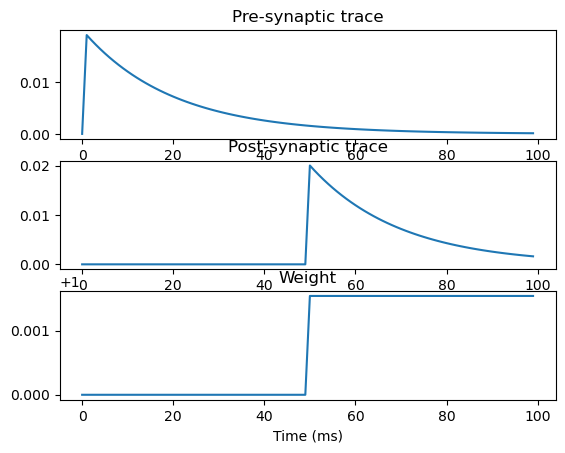

In [8]:
# Reset the populations
reset()

# Set the spike times
pre.spike_times = [[0.0]]
post.spike_times = [[50.0]]

# Simulate
m.resume()
simulate(100.)
data = m.get()

# Plot
plt.figure()
plt.subplot(311)
plt.plot(data['x'][:, 0, 0])
plt.title("Pre-synaptic trace")
plt.subplot(312)
plt.plot(data['y'][:, 0, 0])
plt.title("Post-synaptic trace")
plt.subplot(313)
plt.plot(data['w'][:, 0, 0])
plt.title("Weight")
plt.xlabel("Time (ms)")
plt.show()

**Experiments:**

1. Vary the pre-synaptic spike time and observe how it impacts `x`, `y` and the weight change.

## STDP figure

Let's now try to reproduce the (Bi and Poo, 2001) figure to check the validity of the online model.

We first reset our "network":

In [9]:
reset()
m.pause() # Stop recording

The presynaptic neuron will fire at various times between 0 and 100 ms, while the postsynaptic neuron keeps firing at 50 ms.

In [10]:
pre_times = np.linspace(100.0, 0.0, 101)
t_post = 50.0

In [11]:
weight_changes = []
for t_pre in pre_times:
    
    # Reset the populations
    pre.clear()
    post.clear()
    pre.spike_times = [[t_pre]]
    post.spike_times = [[t_post]]
    
    # Reset the traces
    proj.x = 0.0
    proj.y = 0.0
    
    # Weight before the simulation (should be 1)
    w_before = proj[0].w[0]
    
    # Simulate long enough
    simulate(105.0)
    
    # Record weight change
    delta_w = 100*(proj[0].w[0] - w_before)
    weight_changes.append(delta_w)

We can now plot the classical STDP figure:

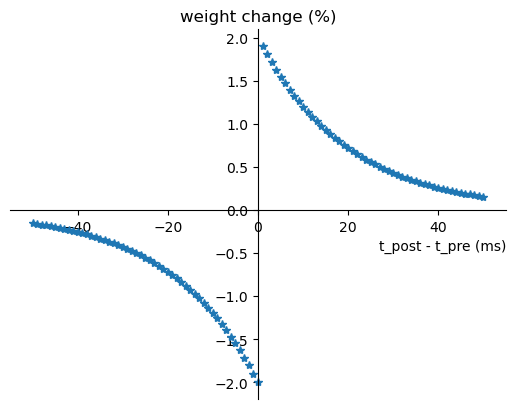

In [12]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.plot(50. - pre_times, weight_changes, "*")
plt.xlabel("t_post - t_pre (ms)", loc='right')
plt.title("weight change (%)")

ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()